<a href="https://colab.research.google.com/github/Cezari0o/PLN-Trab/blob/main/projeto_final/%5BPLN%5D_Projeto_Final_RNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project PLN - CNN
Gabriel Cesário Silva Martins - 180100912 

In this notebook, the training of a convolutional neural network is done. It is a similar process to the one made on the LSTM model.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ln --symbolic /content/drive/MyDrive/UnB/PLN/projeto_final/ /dir
%cd /dir/.
!ls .

/content/drive/.shortcut-targets-by-id/1yd_wnDhuc_GPjRYs6OAA3jtLMaLl8SXF/UnB/PLN/projeto_final
LSTM_Classifier		       Mental-Health-Twitter-pre-processed.csv
Mental-Health-Twitter.csv      projeto_final
Mental-Health-Twitter.csv.zip  RNN_Classifier


# Imports

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report

# Loading the dataset

In [5]:
df = pd.read_csv('Mental-Health-Twitter-pre-processed.csv')
df = df.drop('Unnamed: 0', axis=1)

In [6]:
df.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label', 'is_retweet',
       'tweet_num_words'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19929 entries, 0 to 19928
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   post_id          19929 non-null  int64 
 1   post_created     19929 non-null  object
 2   post_text        19929 non-null  object
 3   user_id          19929 non-null  int64 
 4   followers        19929 non-null  int64 
 5   friends          19929 non-null  int64 
 6   favourites       19929 non-null  int64 
 7   statuses         19929 non-null  int64 
 8   retweets         19929 non-null  int64 
 9   label            19929 non-null  int64 
 10  is_retweet       19929 non-null  int64 
 11  tweet_num_words  19929 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 1.8+ MB


# Data Splitting

In [8]:
random_seed = 168
x_train, x_rest, y_train, y_rest = train_test_split(df['post_text'], df['label'], random_state = random_seed, test_size=0.2, shuffle=True)

In [9]:
x_valid, x_test, y_valid, y_test = train_test_split(x_rest, y_rest, random_state = random_seed, test_size=0.5, shuffle=True)

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [11]:
train_sequences = tokenizer.texts_to_sequences(x_train)

In a previous notebook, the estimated size for the vectors in the embedding layer was already estimated (at 27), so the same size will be used here

In [12]:
max_len = 27
trunc_type = 'post'
padding_type = 'post'
train_padded = pad_sequences(train_sequences, maxlen= max_len, padding=padding_type, truncating=trunc_type)

In [13]:
valid_sequences = tokenizer.texts_to_sequences(x_valid)
test_sequences = tokenizer.texts_to_sequences(x_test)

valid_padded = pad_sequences(valid_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# Handling the output

In [14]:
y_train = pd.Categorical(y_train)
y_train_int = y_train.codes

y_valid = pd.Categorical(y_valid)
y_valid_int = y_valid.codes

y_test = pd.Categorical(y_test)
y_test_int = y_test.codes

In [15]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

# Building and Training the Network

In [16]:
model = Sequential(layers = [
    Input(shape=[max_len]),
    Embedding(input_dim = len(tokenizer.word_counts), output_dim = 512),
    Conv1D(kernel_size = 3, filters = 128, activation='relu', padding='same', strides=4),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2),

    Conv1D(kernel_size = 6, filters = 128, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2),

    Conv1D(kernel_size = 12, filters = 128, activation='relu', padding='same'),
    # MaxPooling1D(pool_size=3, strides=2),
    GlobalMaxPooling1D(),

    Dense(units=512, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=16,  activation='relu'),
    Dense(units=2,   activation='softmax'),
], name = "RNN_Classifier")

model.summary()

Model: "RNN_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 512)           8287744   
                                                                 
 conv1d (Conv1D)             (None, 7, 128)            196736    
                                                                 
 batch_normalization (BatchN  (None, 7, 128)           512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 128)            98432     
                                                                 
 batch_normalization_1 (Batc  (None, 3, 128)        

In [17]:
adam_optimizer = Adam(learning_rate=0.002)
model.compile(loss="categorical_crossentropy",optimizer=adam_optimizer,metrics=['accuracy'])
train_history = model.fit(train_padded, y_train, validation_data=(valid_padded, y_valid), epochs=50, batch_size=32)

Epoch 1/50
499/499 [==============================] - 18s 12ms/step - loss: 0.5792 - accuracy: 0.6832 - val_loss: 0.4814 - val_accuracy: 0.7471
Epoch 2/50
499/499 [==============================] - 6s 11ms/step - loss: 0.3192 - accuracy: 0.8603 - val_loss: 0.5285 - val_accuracy: 0.7446
Epoch 3/50
499/499 [==============================] - 6s 11ms/step - loss: 0.1685 - accuracy: 0.9285 - val_loss: 0.6023 - val_accuracy: 0.7366
Epoch 4/50
499/499 [==============================] - 6s 12ms/step - loss: 0.1132 - accuracy: 0.9544 - val_loss: 0.8607 - val_accuracy: 0.7180
Epoch 5/50
499/499 [==============================] - 5s 11ms/step - loss: 0.0880 - accuracy: 0.9653 - val_loss: 0.8722 - val_accuracy: 0.7371
Epoch 6/50
499/499 [==============================] - 5s 11ms/step - loss: 0.0792 - accuracy: 0.9695 - val_loss: 0.9370 - val_accuracy: 0.7291
Epoch 7/50
499/499 [==============================] - 5s 11ms/step - loss: 0.0609 - accuracy: 0.9766 - val_loss: 1.1285 - val_accuracy: 0.741

Plotting the loss training history.

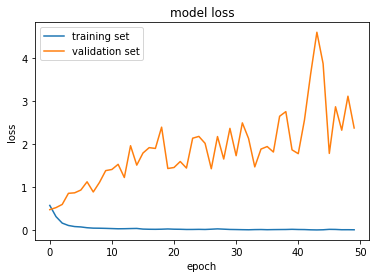

In [18]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

# Testing the Model

In [19]:
y_prob = model.predict(test_padded)
# y_pred = np.argmax(y_prob,axis=1)
y_pred = np.where(y_prob >= 0.5, 1, 0)

In [20]:
print(classification_report(y_test,y_pred, zero_division=0, digits=3))

              precision    recall  f1-score   support

           0      0.736     0.766     0.750      1017
           1      0.745     0.713     0.729       976

   micro avg      0.740     0.740     0.740      1993
   macro avg      0.740     0.740     0.740      1993
weighted avg      0.740     0.740     0.740      1993
 samples avg      0.740     0.740     0.740      1993



## Salvando o modelo

In [21]:
model.save(filepath='RNN_Classifier/.')